In [1]:
!pip install gurobipy

# 1) Import Librieries

In [2]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import pandas as pd
import matplotlib.pyplot as plt

# 2) Primal problem

In [3]:
#Variables

T = 240  #Total lenght in months (20 years)
B = 500_000  #Total amount to finance

#Avaible loans

loans = ["A", "B", "C", "D"]
r = {"A": 0.00267, "B": 0.00250, "C": 0.00233, "D": 0.00217}
T_i = {"A": 240, "B": 180, "C": 120, "D": 60}
b_i = {"A": 250_000, "B": 150_000, "C": 75_000, "D": 50_000}
m_i = {"A": 600, "B": 500, "C": 450, "D": 400}

#Model construction

model = Model("primal")

x = {}                              #Monthly payments
u = {}                              #Outstanding principal

for i in loans:
    for t in range(T_i[i] + 1):
        u[t, i] = model.addVar(lb=0)
    for t in range(1, T_i[i] + 1):
        x[t, i] = model.addVar()

k = model.addVar(lb=0)

#Constraints

#1 Constant monthly installment
for t in range(1, T + 1):
    model.addConstr(gp.quicksum(x[t, i] for i in loans if t <= T_i[i]) == k)

#2 Initial residual capital <= Maximum amount avaiable
for i in loans:
    model.addConstr(u[0, i] <= b_i[i])

#3 Residual capital evolution
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(u[t, i] == u[t - 1, i] * (1 + r[i]) - x[t, i])

#4 Final residual capital equal to 0
for i in loans:
    model.addConstr(u[T_i[i], i] == 0)

#5 Total amount financed equal to B
model.addConstr(gp.quicksum(u[0, i] for i in loans) == B)

#6 Minimum installment constraint x >= m_i
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(x[t, i] >= m_i[i])

#Objective function: minimize the constant monthly installment

model.setObjective(k, GRB.MINIMIZE)

#Optimize

model.optimize()

#Output

if model.status == GRB.OPTIMAL:
    print(f"\n Optimal monthly installment: €{k.X:.2f}")
    for i in loans:
        print(f"\nLoan {i}:")
        for t in range(1, T_i[i] + 1):
            print(f"  Month {t:3}: payment = €{x[t, i].X:.2f}")
else:
    print("No optimal solution found.")

Restricted license - for non-production use only - expires 2026-11-23


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1449 rows, 1205 columns and 3252 nonzeros
Model fingerprint: 0x0ac88271
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 5e+05]
Presolve removed 1264 rows and 660 columns
Presolve time: 0.02s
Presolved: 185 rows, 545 columns, 1269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9480490e+03   2.220943e+04   0.000000e+00      0s
     394    2.7922152e+03   0.000000e+00   0.000000e+00      0s

Solved in 394 iterations and 0.03 seconds (0.01 work units)
Optimal objective  2.792215200e+03

 Optimal monthly installment: €2792.22

Loan A:
  Month   1: payment = €1442.22
  Month   2

## 2.a) Installment composition

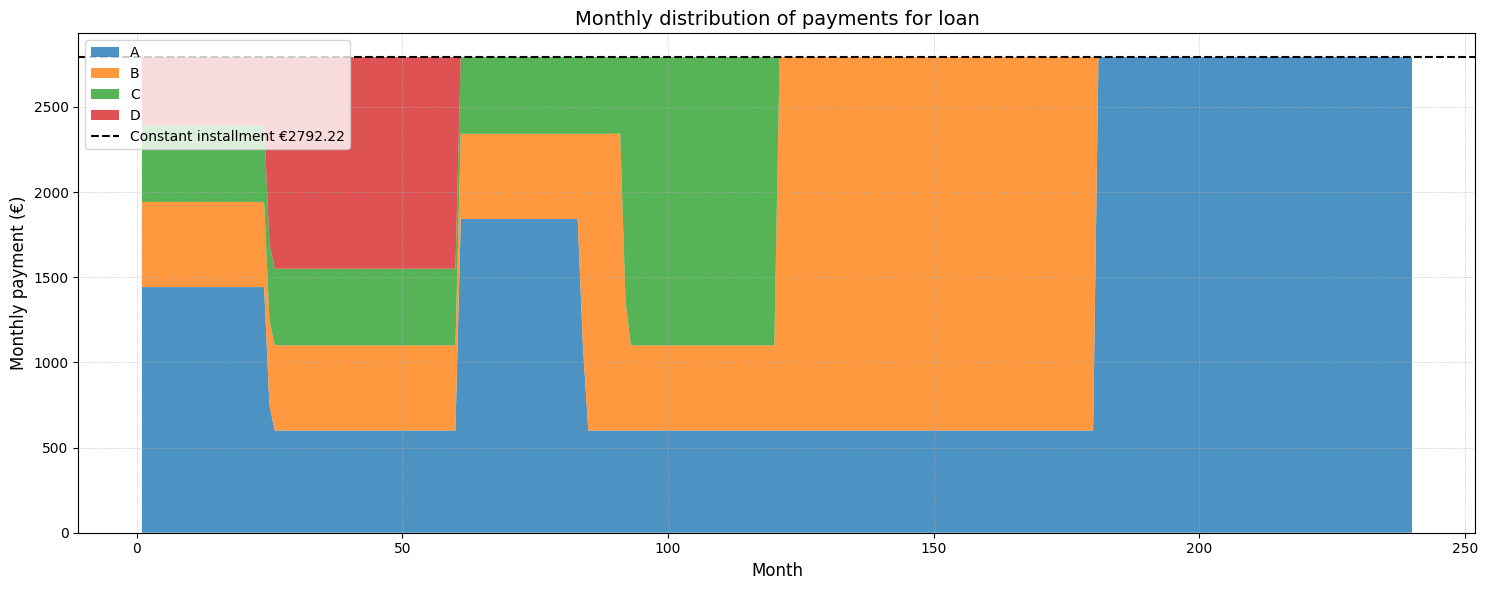

In [4]:
#Build dataset that contains all the payments
data = []

for t in range(1, T + 1):
    row = {"month": t}
    for i in loans:
        row[i] = x[t, i].X if t <= T_i[i] else 0.0
    data.append(row)

df = pd.DataFrame(data)

#Plot stacked area chart (payments for loan over time)
plt.figure(figsize=(15, 6))
plt.stackplot(df["month"], [df[i] for i in loans], labels=loans, alpha=0.8)

#Constant installment showed as orizontal line
plt.axhline(k.X, color='black', linestyle='--', linewidth=1.5,
            label='Constant installment €{:.2f}'.format(k.X))

#Labels and style
plt.title("Monthly distribution of payments for loan", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Monthly payment (€)", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# 3) Primal problem in standard form

In [5]:
#Variables

T = 240  #Total lenght in months (20 years)
B = 500_000  #Total amount to finance

loans = ["A", "B", "C", "D"]
r  = {"A": 0.00267, "B": 0.00250, "C": 0.00233, "D": 0.00217}
T_i = {"A": 240, "B": 180, "C": 120, "D":  60}
b_i = {"A": 250_000, "B": 150_000, "C":  75_000, "D": 50_000}
m_i = {"A":     600, "B":     500, "C":     450, "D":    400}

#Model in standard form

model = Model("standard primal")

x = {}                                #Monthly payments
u = {}                                #Outstanding principal
s_b = {}                              #Slack for constraint u0_i ≤ b_i
s_m = {}                              #Slack for constraint x ≥ m_i
k = model.addVar()                    #Monthly installmant to minimize

#Creation of u_{t,i}
for i in loans:
    for t in range(T_i[i] + 1):      
        u[t, i] = model.addVar()

#Creation of x_{t,i} and slack s_m[t,i]  (constraint x - s_m = m_i)
for i in loans:
    for t in range(1, T_i[i] + 1):
        x[t, i]   = model.addVar()
        s_m[t, i] = model.addVar()

#Slack variables for maximal loan
for i in loans:
    s_b[i] = model.addVar()

model.update()   #register all the variables

#Constraints (only in equality form)

#1 Constant monthly installment
for t in range(1, T + 1):
    model.addConstr(gp.quicksum(x[t, i] for i in loans if t <= T_i[i]) - k == 0)

#2 Initial residual capital + slack variable = avaiable amount
for i in loans:
    model.addConstr(u[0, i] + s_b[i] == b_i[i])

#3 Residual capital evolution
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(u[t, i] - (1 + r[i]) * u[t - 1, i] + x[t, i] == 0)

#4 Final residual capital = 0
for i in loans:
    model.addConstr(u[T_i[i], i] == 0)

#5 Total amount financed = B
model.addConstr(gp.quicksum(u[0, i] for i in loans) == B)

#6 Minimum installment constraint  x - s_m = m_i
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(x[t, i] - s_m[t, i] == m_i[i])

#Objective function: minimize

model.setObjective(k, GRB.MINIMIZE)

#Optimize

model.optimize()

#Output

if model.Status == GRB.OPTIMAL:
    print(f"\n Optimal monthly installment: €{k.X:.2f}")
    for i in loans:
        print(f"\nLoan {i}:")
        for t in range(1, T_i[i] + 1):
            print(f"  Month {t:3}: payment = €{x[t, i].X:.2f}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1449 rows, 1809 columns and 3856 nonzeros
Model fingerprint: 0x18b8aa1f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 5e+05]
Presolve removed 1264 rows and 1264 columns
Presolve time: 0.02s
Presolved: 185 rows, 545 columns, 1269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9480490e+03   2.220943e+04   0.000000e+00      0s
     393    2.7922152e+03   0.000000e+00   0.000000e+00      0s

Solved in 393 iterations and 0.03 seconds (0.01 work units)
Optimal objective  2.792215200e+03

 Optimal monthly installment: €2792.22

Loan A:
  Month   1: payment = €1442.22
  Month   

# 4) Dual problem

In [6]:
#Variables

T  = 240
B  = 500_000

loans = ["A", "B", "C", "D"]
r     = {"A": 0.00267, "B": 0.00250, "C": 0.00233, "D": 0.00217}
T_i   = {"A": 240, "B": 180, "C": 120, "D":  60}
b_i   = {"A": 250_000, "B": 150_000, "C":  75_000, "D": 50_000}
m_i   = {"A":     600, "B":     500, "C":     450, "D":    400}

#Dual model construction

dual = Model("dual")

y1 = {t: dual.addVar(lb=-GRB.INFINITY)             #From constant installment constraint
      for t in range(1, T+1)}

y2 = {i: dual.addVar(lb=-GRB.INFINITY)             #From u0_i + s_b = b_i constraint
      for i in loans}

y3 = {(i, t): dual.addVar(lb=-GRB.INFINITY)        #From residual evolution constraint
      for i in loans for t in range(1, T_i[i]+1)}

y4 = {i: dual.addVar(lb=-GRB.INFINITY)             #From u_Ti,i = 0 constraint
      for i in loans}

y5 = dual.addVar(lb=-GRB.INFINITY)                 #From initial residual capital constraint

y6 = {(i, t): dual.addVar(lb=-GRB.INFINITY)        #From x - s_m = m_i constraint
      for i in loans for t in range(1, T_i[i]+1)}

dual.update()

#Objective function: maximize

dual.setObjective(
      gp.quicksum(b_i[i] * y2[i] for i in loans)
    + B * y5
    + gp.quicksum(m_i[i] * y6[i, t] for i in loans for t in range(1, T_i[i]+1)),
    GRB.MAXIMIZE)

#Dual constraints

#(a) Variables x[t,i]
for i in loans:
    for t in range(1, T_i[i]+1):dual.addConstr(y1[t] + y3[i, t] + y6[i, t] <= 0)

#(b) Variable k
dual.addConstr(-gp.quicksum(y1[t] for t in range(1, T+1)) <= 1)

#(c) Variables s_m[t,i]
for i in loans:
    for t in range(1, T_i[i]+1):dual.addConstr(-y6[i, t] <= 0)

#(d) Variables s_b[i]
for i in loans:
    dual.addConstr(y2[i] <= 0)

#(e) Variables u[0,i]
for i in loans:
    dual.addConstr(y2[i] - (1 + r[i]) * y3[i, 1] + y5 <= 0)

#(f) Varables u[t,i]
for i in loans:
    for t in range(1, T_i[i]):dual.addConstr(y3[i, t] - (1 + r[i]) * y3[i, t+1] <= 0)

#(g) Variables u[T_i,i]
for i in loans:
    dual.addConstr(y3[i, T_i[i]] + y4[i] <= 0)

#Optimize

dual.optimize()

#Output

if dual.Status == GRB.OPTIMAL:
    print(f"\nOptimal value for Dual: €{dual.ObjVal:.2f}")
else:
    print("No optimal solution found for Dual.")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1809 rows, 1449 columns and 3856 nonzeros
Model fingerprint: 0xfefe9af8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1445 rows and 901 columns
Presolve time: 0.02s
Presolved: 364 rows, 548 columns, 1636 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     553    2.7922158e+03   0.000000e+00   0.000000e+00      0s

Solved in 553 iterations and 0.04 seconds (0.03 work units)
Optimal objective  2.792215776e+03

Optimal value for Dual: €2792.22


# 5) Complementary slackness

In [7]:
#(a) Variables x[t,i]
for i in loans:
    for t in range(1, T_i[i]+1):
      if (y1[t].X + y3[i, t].X + y6[i, t].X - 0)*x[t,i].X != 0:
        print('Violation of slackness linked to constraint (a), loan ', i, ' time ', t, ' quantity ', (y1[t].X + y3[i, t].X + y6[i, t].X)*x[t,i].X)
          
#(b) Variables k
for i in loans:
    for t in range(1, T_i[i]+1):
        if (1 + y1[t].X)*k.X != 0:
            print('Violation of slackness linked to constraint (b), loan ', i, ' time ', t, ' quantity ', (y1[t].X + y3[i, t].X + y6[i, t].X)*x[t,i].X)
            
#(c) Variables s_m[t,i]
for i in loans:
    for t in range(1, T_i[i]+1):
        if (0+y6[i, t].X)*s_m[t,i].X != 0:
            print('Violation of slackness linked to constraint (c), loan ', i, ' time ', t, ' quantity ', (0+y6[i, t].X)*s_m[t,i].X)
            
#(d) Variables s_b[i]
for i in loans:
      if (0-y2[i].X)*s_b[i].X != 0:
        print('Violation of slackness linked to constraint (d), loan ', i,' quantity ', (0-y2[i].X)*s_b[i].X)
          
#(e) Variables u[0,i]
for i in loans:
    if (0-y2[i].X+(1 + r[i]) * y3[i, 1].X-y5.X)*u[0,i].X != 0:
        print('Violation of slackness linked to constraint (c), loan ', i,' quantity ', (0-y2[i].X+(1 + r[i]) * y3[i, 1].X-y5.X)*u[0,i].X)
        
#(f) Variables u[t,i]
for i in loans:
    for t in range(1, T_i[i]):
        if (0 - y3[i, t].X + (1 + r[i]) * y3[i, t + 1].X) * u[t, i].X != 0:
            print('Violation of slackness linked to constraint (f), loan ', i, ' time ', t,
                  ' quantity ', (0 - y3[i, t].X + (1 + r[i]) * y3[i, t + 1].X) * u[t, i].X)

#(g) Variables u[T_i,i]
for i in loans:
    if (0 - y3[i, T_i[i]].X + y4[i].X) * u[T_i[i], i].X != 0:
        print('Violation of slackness linked to constraint (g), loan ', i,' quantity ', (0 - y3[i, T_i[i]].X + y4[i].X) * u[T_i[i], i].X)


Violation of slackness linked to constraint (a), loan  C  time  120  quantity  -1.4677627172540591e-15
Violation of slackness linked to constraint (b), loan  A  time  1  quantity  0.0
Violation of slackness linked to constraint (b), loan  A  time  2  quantity  0.0
Violation of slackness linked to constraint (b), loan  A  time  3  quantity  0.0
Violation of slackness linked to constraint (b), loan  A  time  4  quantity  0.0
Violation of slackness linked to constraint (b), loan  A  time  5  quantity  0.0
Violation of slackness linked to constraint (b), loan  A  time  6  quantity  0.0
Violation of slackness linked to constraint (b), loan  A  time  7  quantity  0.0
Violation of slackness linked to constraint (b), loan  A  time  8  quantity  0.0
Violation of slackness linked to constraint (b), loan  A  time  9  quantity  0.0
Violation of slackness linked to constraint (b), loan  A  time  10  quantity  0.0
Violation of slackness linked to constraint (b), loan  A  time  11  quantity  0.0
Viol

## 5.a) Check slackness violation in constrain (c)

In [8]:
print(f"s_m[84, B] = {s_m[84, 'B'].X}")
print(f"dual slack[84, B] = {y6['B', 84].X}")

s_m[84, B] = 755.6849539697578
dual slack[84, B] = -7.618884772060339e-07


## 5.b) Check slackness violation in constrain (f)

In [9]:
print(f"u[2, 'A'] = {u[2, 'A'].X}")
print(f"dual slack[2, 'A'] = {-y3['A', 2].X + (1 + r['A']) * y3['A', 3].X}")

print(f"u[4, 'A'] = {u[4, 'A'].X}")
print(f"dual slack[4, 'A'] = {-y3['A', 4].X + (1 + r['A']) * y3['A', 5].X}")

print(f"u[18, 'A'] = {u[18, 'A'].X}")
print(f"dual slack[18, 'A'] = {-y3['A', 18].X + (1 + r['A']) * y3['A', 19].X}")

u[2, 'A'] = 223314.82288715022
dual slack[2, 'A'] = 8.239936510889834e-17
u[4, 'A'] = 221620.63491505868
dual slack[4, 'A'] = 1.3530843112619095e-16
u[18, 'A'] = 209504.9351082685
dual slack[18, 'A'] = -7.112366251504909e-17


# 6) Sensitivity analysis

## 6.a) Scenario 1: growth of all interest rates of 0.5%

In [10]:
#Variables

T = 240  #Total lenght in months (20 years)
B = 500_000  #Total amount to finance

#Avaible loans

loans = ["A", "B", "C", "D"]
r = {"A": 0.003087, "B": 0.002917, "C": 0.002747, "D": 0.002587}
T_i = {"A": 240, "B": 180, "C": 120, "D": 60}
b_i = {"A": 250_000, "B": 150_000, "C": 75_000, "D": 50_000}
m_i = {"A": 600, "B": 500, "C": 450, "D": 400}

#Model construction

model = Model("scenario_1")

x = {}                              #Monthly payments
u = {}                              #Outstanding principal

for i in loans:
    for t in range(T_i[i] + 1):
        u[t, i] = model.addVar(lb=0)
    for t in range(1, T_i[i] + 1):
        x[t, i] = model.addVar()

k = model.addVar(lb=0)

# Constraints

#1 Constant monthly installment
for t in range(1, T + 1):
    model.addConstr(gp.quicksum(x[t, i] for i in loans if t <= T_i[i]) == k)

#2 Initial residual capital <= Maximum amount avaiable
for i in loans:
    model.addConstr(u[0, i] <= b_i[i])

#3 Residual capital evolution
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(u[t, i] == u[t - 1, i] * (1 + r[i]) - x[t, i])

#4 Final residual capital equal to 0
for i in loans:
    model.addConstr(u[T_i[i], i] == 0)

#5 Total amount financed equal to B
model.addConstr(gp.quicksum(u[0, i] for i in loans) == B)

#6 Minimum installment constraint x >= m_i
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(x[t, i] >= m_i[i])

#Objective function: minimize the constant monthly installment

model.setObjective(k, GRB.MINIMIZE)

#Optimize

model.optimize()

#Output

if model.status == GRB.OPTIMAL:
    print(f"\n Optimal monthly installment: €{k.X:.2f}")
    for i in loans:
        print(f"\nLoan {i}:")
        for t in range(1, T_i[i] + 1):
            print(f"  Month {t:3}: payment = €{x[t, i].X:.2f}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1449 rows, 1205 columns and 3252 nonzeros
Model fingerprint: 0x78c11b71
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 5e+05]
Presolve removed 1264 rows and 660 columns
Presolve time: 0.01s
Presolved: 185 rows, 545 columns, 1269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9480490e+03   2.556424e+04   0.000000e+00      0s
     396    2.9188498e+03   0.000000e+00   0.000000e+00      0s

Solved in 396 iterations and 0.02 seconds (0.01 work units)
Optimal objective  2.918849810e+03

 Optimal monthly installment: €2918.85

Loan A:
  Month   1: payment = €1568.85
  Month   2

## Installment composition

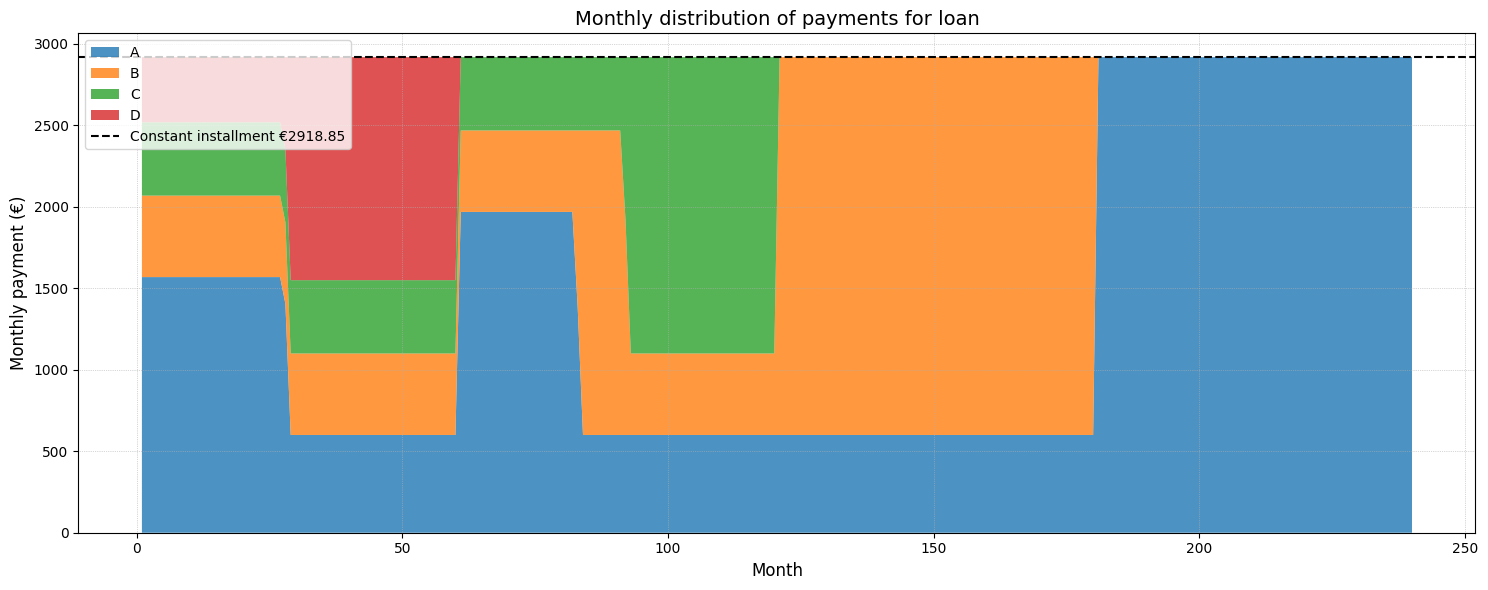

In [11]:
#Built dataset that contains all the payments
data = []

for t in range(1, T + 1):
    row = {"month": t}
    for i in loans:
        row[i] = x[t, i].X if t <= T_i[i] else 0.0
    data.append(row)

df = pd.DataFrame(data)

#Plot stacked area chart (payments for loan over time)
plt.figure(figsize=(15, 6))
plt.stackplot(df["month"], [df[i] for i in loans], labels=loans, alpha=0.8)

#Constant installment showed as orizontal line
plt.axhline(k.X, color='black', linestyle='--', linewidth=1.5,
            label='Constant installment €{:.2f}'.format(k.X))

#Labels and style
plt.title("Monthly distribution of payments for loan", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Monthly payment (€)", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

## 6.b) Scenario 2: the financial plafond of the cheapest loan (D) is increased by 50k

In [12]:
#Variables

T = 240  #Total lenght in months (20 years)
B = 500_000  #Total amount to finance

#Avaible loans

loans = ["A", "B", "C", "D"]
r = {"A": 0.00267, "B": 0.00250, "C": 0.00233, "D": 0.00217}
T_i = {"A": 240, "B": 180, "C": 120, "D": 60}
b_i = {"A": 250_000, "B": 150_000, "C": 75_000, "D": 100_000}
m_i = {"A": 600, "B": 500, "C": 450, "D": 400}

#Model construction

model = Model("scenario_2")

x = {}                              #Monthly payments
u = {}                              #Outstanding principal

for i in loans:
    for t in range(T_i[i] + 1):
        u[t, i] = model.addVar(lb=0)
    for t in range(1, T_i[i] + 1):
        x[t, i] = model.addVar()

k = model.addVar(lb=0)

#Constraints

#1 Constant monthly installment
for t in range(1, T + 1):
    model.addConstr(gp.quicksum(x[t, i] for i in loans if t <= T_i[i]) == k)

#2 Initial residual capital <= Maximum amount avaiable
for i in loans:
    model.addConstr(u[0, i] <= b_i[i])

#3 Residual capital evolution
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(u[t, i] == u[t - 1, i] * (1 + r[i]) - x[t, i])

#4 Final residual capital equal to 0
for i in loans:
    model.addConstr(u[T_i[i], i] == 0)

#5 Total amount financed equal to B
model.addConstr(gp.quicksum(u[0, i] for i in loans) == B)

#6 Minimum installment constraint x >= m_i
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(x[t, i] >= m_i[i])

#Objective function: minimize the constant monthly installment

model.setObjective(k, GRB.MINIMIZE)

#Optimize

model.optimize()

#Output

if model.status == GRB.OPTIMAL:
    print(f"\n Optimal monthly installment: €{k.X:.2f}")
    for i in loans:
        print(f"\nLoan {i}:")
        for t in range(1, T_i[i] + 1):
            print(f"  Month {t:3}: payment = €{x[t, i].X:.2f}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1449 rows, 1205 columns and 3252 nonzeros
Model fingerprint: 0x3a1821ab
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 5e+05]
Presolve removed 1264 rows and 660 columns
Presolve time: 0.01s
Presolved: 185 rows, 545 columns, 1269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9480490e+03   2.880985e+04   0.000000e+00      0s
     363    2.7915266e+03   0.000000e+00   0.000000e+00      0s

Solved in 363 iterations and 0.02 seconds (0.01 work units)
Optimal objective  2.791526595e+03

 Optimal monthly installment: €2791.53

Loan A:
  Month   1: payment = €600.00
  Month   2:

## Installment composition

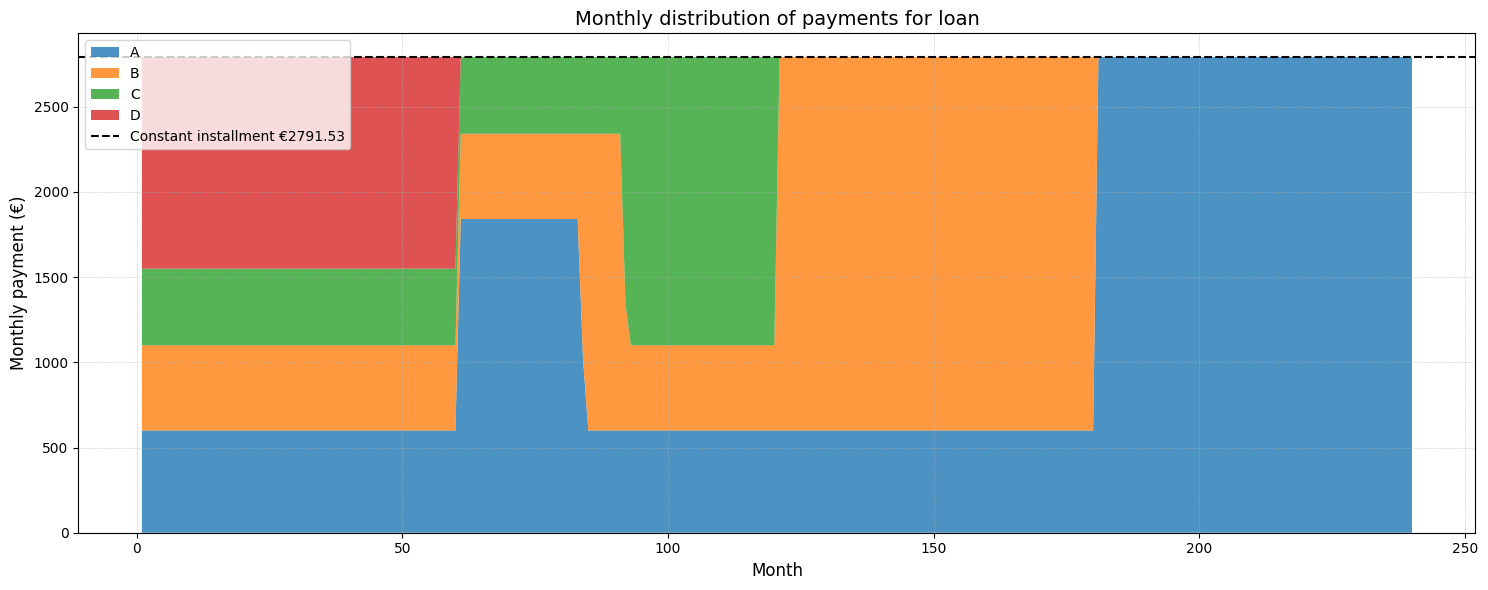

In [13]:
#Built dataset that contains all the payments
data = []

for t in range(1, T + 1):
    row = {"month": t}
    for i in loans:
        row[i] = x[t, i].X if t <= T_i[i] else 0.0
    data.append(row)

df = pd.DataFrame(data)

#Plot stacked area chart (payments for loan over time)
plt.figure(figsize=(15, 6))
plt.stackplot(df["month"], [df[i] for i in loans], labels=loans, alpha=0.8)

#Constant installment showed as orizontal line
plt.axhline(k.X, color='black', linestyle='--', linewidth=1.5,
            label='Constant installment €{:.2f}'.format(k.X))

#Labels and style
plt.title("Monthly distribution of payments for loan", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Monthly payment (€)", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

## 6.c) Scenario 3: disapper loan C and loans A and B offer larger plafonds

In [14]:
#Variables

T = 240  #Total lenght in months (20 years)
B = 500_000  #Total amount to finance

#Avaible loans

loans = ["A", "B", "D"]
r = {"A": 0.00267, "B": 0.00250, "D": 0.00217}
T_i = {"A": 240, "B": 180, "D": 60}
b_i = {"A": 275_000, "B": 175_000, "D": 50_000}
m_i = {"A": 600, "B": 500, "D": 400}

#Model construction

model = Model("scenario_3")

x = {}                              #Monthly payments
u = {}                              #Outstanding principal

for i in loans:
    for t in range(T_i[i] + 1):
        u[t, i] = model.addVar(lb=0)
    for t in range(1, T_i[i] + 1):
        x[t, i] = model.addVar()

k = model.addVar(lb=0)

#Constraints

#1 Constant monthly installment
for t in range(1, T + 1):
    model.addConstr(gp.quicksum(x[t, i] for i in loans if t <= T_i[i]) == k)

#2 Initial residual capital <= Maximum amount avaiable
for i in loans:
    model.addConstr(u[0, i] <= b_i[i])

#3 Residual capital evolution
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(u[t, i] == u[t - 1, i] * (1 + r[i]) - x[t, i])

#4 Final residual capital equal to 0
for i in loans:
    model.addConstr(u[T_i[i], i] == 0)

#5 Total amount financed equal to B
model.addConstr(gp.quicksum(u[0, i] for i in loans) == B)

#6 Minimum installment constraint x >= m_i
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(x[t, i] >= m_i[i])

#Objective function: minimize the constant monthly installment

model.setObjective(k, GRB.MINIMIZE)

#Optimize

model.optimize()

#Output

if model.status == GRB.OPTIMAL:
    print(f"\n Optimal monthly installment: €{k.X:.2f}")
    for i in loans:
        print(f"\nLoan {i}:")
        for t in range(1, T_i[i] + 1):
            print(f"  Month {t:3}: payment = €{x[t, i].X:.2f}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1207 rows, 964 columns and 2649 nonzeros
Model fingerprint: 0x70bf7e1b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 5e+05]
Presolve removed 1024 rows and 543 columns
Presolve time: 0.01s
Presolved: 183 rows, 421 columns, 1021 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4984990e+03   3.424157e+04   0.000000e+00      0s
     349    2.7997235e+03   0.000000e+00   0.000000e+00      0s

Solved in 349 iterations and 0.02 seconds (0.01 work units)
Optimal objective  2.799723540e+03

 Optimal monthly installment: €2799.72

Loan A:
  Month   1: payment = €1899.72
  Month   2:

## Installment composition

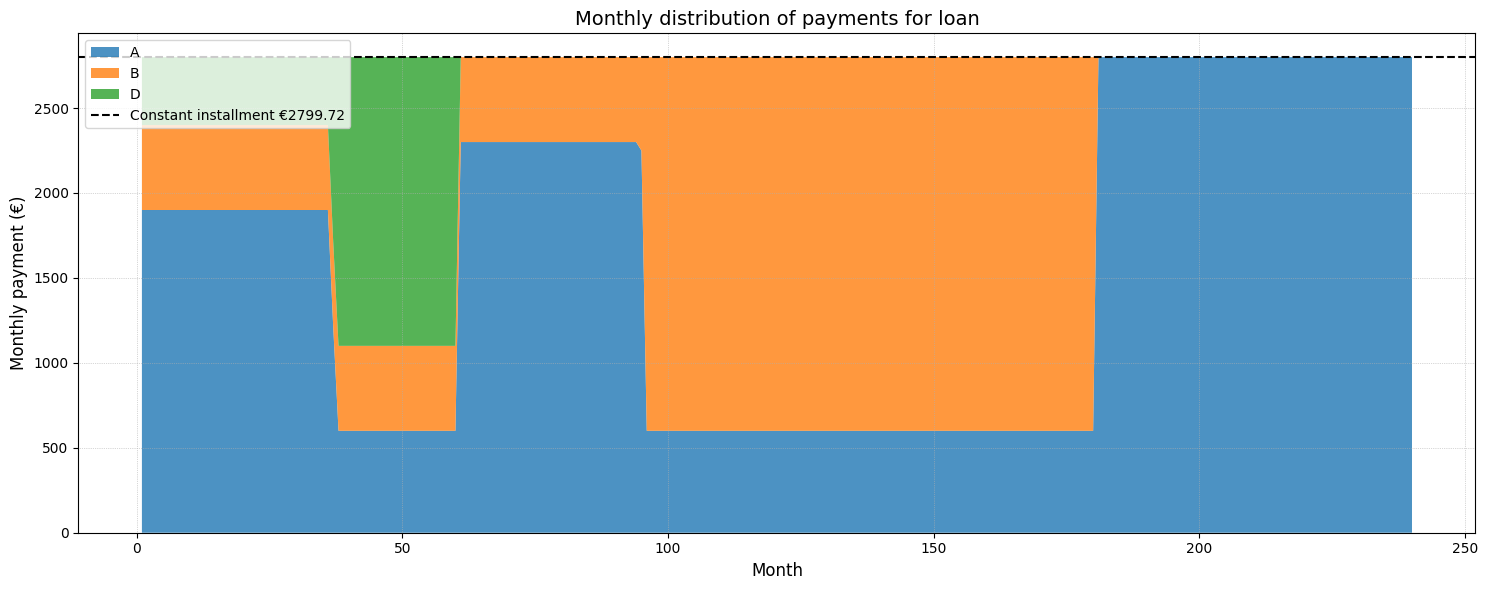

In [15]:
#Built dataset that contains all the payments
data = []

for t in range(1, T + 1):
    row = {"month": t}
    for i in loans:
        row[i] = x[t, i].X if t <= T_i[i] else 0.0
    data.append(row)

df = pd.DataFrame(data)

#Plot stacked area chart (payments for loan over time)
plt.figure(figsize=(15, 6))
plt.stackplot(df["month"], [df[i] for i in loans], labels=loans, alpha=0.8)

#Constant installment showed as orizontal line
plt.axhline(k.X, color='black', linestyle='--', linewidth=1.5,
            label='Constant installment €{:.2f}'.format(k.X))

#Labels and style
plt.title("Monthly distribution of payments for loan", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Monthly payment (€)", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# 7) Sensitivity report

## 7.a) Rewrite the primal problem naming the objects

In [16]:
#Variables
T = 240  #Total length in months (20 years)
B = 500_000  #Total amount to finance

#Available loans
loans = ["A", "B", "C", "D"]
r = {"A": 0.00267, "B": 0.00250, "C": 0.00233, "D": 0.00217}
T_i = {"A": 240, "B": 180, "C": 120, "D": 60}
b_i = {"A": 250_000, "B": 150_000, "C": 75_000, "D": 50_000}
m_i = {"A": 600, "B": 500, "C": 450, "D": 400}

#Model construction
model = Model("primal")

x = {}                              #Monthly payments
u = {}                              #Outstanding principal

for i in loans:
    for t in range(T_i[i] + 1):
        u[t, i] = model.addVar(lb=0, name=f"u[{t},{i}]")
    for t in range(1, T_i[i] + 1):
        x[t, i] = model.addVar(name=f"x[{t},{i}]")

k = model.addVar(lb=0, name="k")

#Constraints

#1 Constant monthly installment
for t in range(1, T + 1):
    model.addConstr(
        gp.quicksum(x[t, i] for i in loans if t <= T_i[i]) == k, name=f"constant_monthly_installment[{t}]")

#2 Initial residual capital <= Maximum available amount
for i in loans:
    model.addConstr(u[0, i] <= b_i[i], name=f"initial_capital_limit[{i}]")

#3 Residual capital evolution
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(
            u[t, i] == u[t - 1, i] * (1 + r[i]) - x[t, i], name=f"capital_evolution[{t},{i}]")

#4 Final residual capital equal to 0
for i in loans:
    model.addConstr(u[T_i[i], i] == 0, name=f"final_capital_zero[{i}]")

#5 Total amount financed equal to B
model.addConstr(
    gp.quicksum(u[0, i] for i in loans) == B, name="total_financed")

#6 Minimum installment constraint x >= m_i
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(
            x[t, i] >= m_i[i], name=f"MinInstallment[{t},{i}]")

#Objective function: minimize the constant monthly installment
model.setObjective(k, GRB.MINIMIZE)

#Optimize
model.optimize()

#Output
if model.status == GRB.OPTIMAL:
    print(f"\nOptimal monthly installment: €{k.X:.2f}")
    for i in loans:
        print(f"\nLoan {i}:")
        for t in range(1, T_i[i] + 1):
            print(f"  Month {t:3}: payment = €{x[t, i].X:.2f}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1449 rows, 1205 columns and 3252 nonzeros
Model fingerprint: 0x0ac88271
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 5e+05]
Presolve removed 1264 rows and 660 columns
Presolve time: 0.02s
Presolved: 185 rows, 545 columns, 1269 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9480490e+03   2.220943e+04   0.000000e+00      0s
     394    2.7922152e+03   0.000000e+00   0.000000e+00      0s

Solved in 394 iterations and 0.03 seconds (0.01 work units)
Optimal objective  2.792215200e+03

Optimal monthly installment: €2792.22

Loan A:
  Month   1: payment = €1442.22
  Month   2:

## 7.b) Report

In [17]:
if model.status == GRB.OPTIMAL:

    var_data = []
    for var in model.getVars():
        if var.RC != 0:
            allow_inc = var.getAttr("SAObjUp")
            allow_dec = var.getAttr("SAObjLow")
            var_data.append([var.VarName, var.RC, allow_inc, allow_dec])

    var_df = pd.DataFrame(var_data, columns=["Variable", "Reduced Cost", "Allowable Increase", "Allowable Decrease"])
    var_df = var_df.reindex(var_df["Reduced Cost"].abs().sort_values(ascending=False).index)

    constr_data = []
    for constr in model.getConstrs():
        pi = constr.getAttr("Pi")
        if pi != 0:
            allow_inc = constr.getAttr("SARHSLow")
            allow_dec = constr.getAttr("SARHSUp")
            constr_data.append([constr.ConstrName, pi, allow_inc, allow_dec])

    constr_df = pd.DataFrame(constr_data, columns=["Constraint", "Shadow Price", "Allowable Increase", "Allowable Decrease"])
    constr_df = constr_df.reindex(constr_df["Shadow Price"].abs().sort_values(ascending=False).index)

    print("\nVariables with reduced cost != 0")
    print(var_df.head(4).round(6))

    print("\nConstraints with shadow price != 0")
    print(constr_df.head(4).round(6))


Variables with reduced cost != 0
Empty DataFrame
Columns: [Variable, Reduced Cost, Allowable Increase, Allowable Decrease]
Index: []

Constraints with shadow price != 0
                          Constraint  Shadow Price  Allowable Increase  \
847                   total_financed      0.005621       499248.226880   
243           capital_evolution[1,A]      0.005606         -753.780354   
0    constant_monthly_installment[1]     -0.005606         -846.963472   
244           capital_evolution[2,A]      0.005591         -755.792948   

     Allowable Decrease  
847       501575.671752  
243         1579.878796  
0            753.780354  
244         1584.097072  


# 8) Change of dataset using also B = 300k

In [18]:
#Variables

T = 240  #Total lenght in months (20 years)
B = 300_000  #Total amount to finance

#Avaible loans

loans = ["A", "B", "C"]
r = {"A": 0.00417, "B": 0.00375, "C": 0.00333}
T_i = {"A": 240, "B": 180, "C": 120}
b_i = {"A": 200_000, "B": 100_000, "C": 75_000}
m_i = {"A": 700, "B": 600, "C": 500}

#Model construction

model = Model("primal_second_version")

x = {}                              #Monthly payments
u = {}                              #Outstanding principal

for i in loans:
    for t in range(T_i[i] + 1):
        u[t, i] = model.addVar(lb=0)
    for t in range(1, T_i[i] + 1):
        x[t, i] = model.addVar()

k = model.addVar(lb=0)

#Constraints

#1 Constant monthly installment
for t in range(1, T + 1):
    model.addConstr(gp.quicksum(x[t, i] for i in loans if t <= T_i[i]) == k)

#2 Initial residual capital <= Maximum amount avaiable
for i in loans:
    model.addConstr(u[0, i] <= b_i[i])

#3 Residual capital evolution
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(u[t, i] == u[t - 1, i] * (1 + r[i]) - x[t, i])

#4 Final residual capital equal to 0
for i in loans:
    model.addConstr(u[T_i[i], i] == 0)

#5 Total amount financed equal to B
model.addConstr(gp.quicksum(u[0, i] for i in loans) == B)

#6 Minimum installment constraint x >= m_i
for i in loans:
    for t in range(1, T_i[i] + 1):
        model.addConstr(x[t, i] >= m_i[i])

#Objective function: minimize the constant monthly installment

model.setObjective(k, GRB.MINIMIZE)

#Optimize

model.optimize()

#Output

if model.status == GRB.OPTIMAL:
    print(f"\n Optimal monthly installment: €{k.X:.2f}")
    for i in loans:
        print(f"\nLoan {i}:")
        for t in range(1, T_i[i] + 1):
            print(f"  Month {t:3}: payment = €{x[t, i].X:.2f}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1327 rows, 1084 columns and 2949 nonzeros
Model fingerprint: 0xe5f8c9e3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 3e+05]
Presolve removed 1143 rows and 600 columns
Presolve time: 0.01s
Presolved: 184 rows, 484 columns, 1147 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7981990e+03   7.575857e+02   0.000000e+00      0s
     226    1.9358737e+03   0.000000e+00   0.000000e+00      0s

Solved in 226 iterations and 0.03 seconds (0.01 work units)
Optimal objective  1.935873674e+03

 Optimal monthly installment: €1935.87

Loan A:
  Month   1: payment = €700.00
  Month   2:

## Installment composition

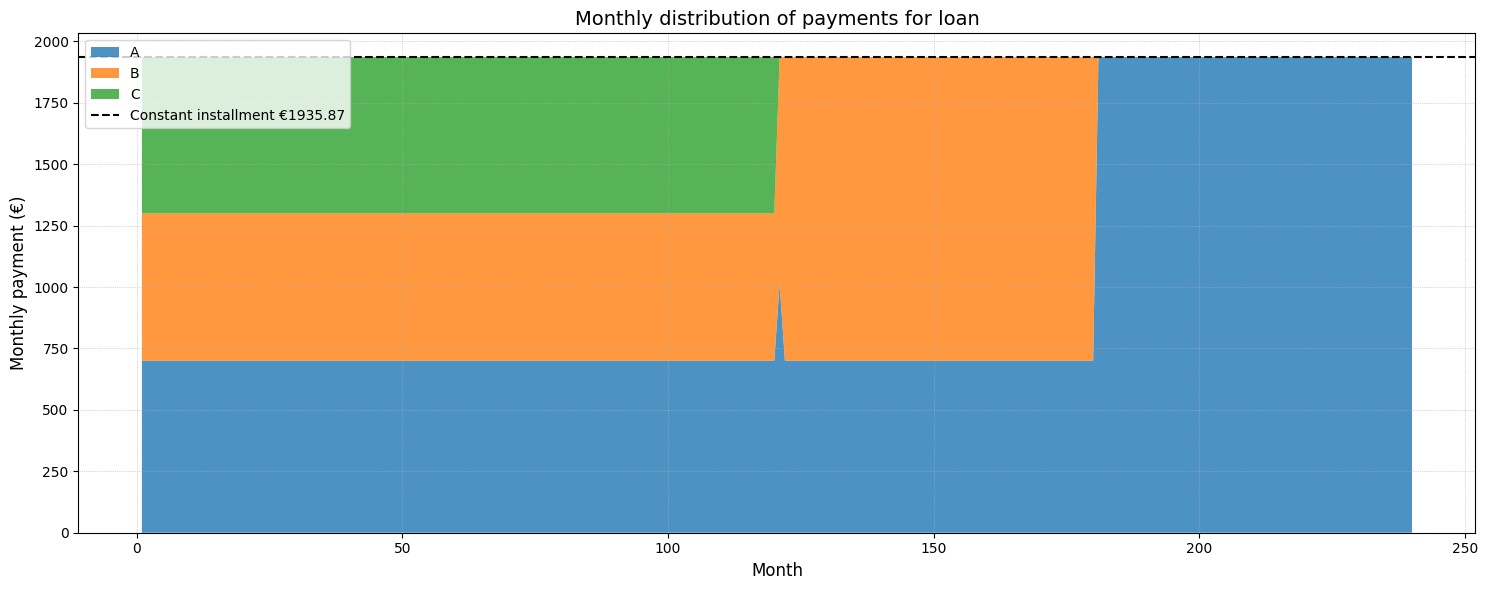

In [19]:
#Built dataset that contains all the payments
data = []

for t in range(1, T + 1):
    row = {"month": t}
    for i in loans:
        row[i] = x[t, i].X if t <= T_i[i] else 0.0
    data.append(row)

df = pd.DataFrame(data)

#Plot stacked area chart (payments for loan over time)
plt.figure(figsize=(15, 6))
plt.stackplot(df["month"], [df[i] for i in loans], labels=loans, alpha=0.8)

#Constant installment showed as orizontal line
plt.axhline(k.X, color='black', linestyle='--', linewidth=1.5,
            label='Constant installment €{:.2f}'.format(k.X))

#Labels and style
plt.title("Monthly distribution of payments for loan", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Monthly payment (€)", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()